_______________________________________

# **Tanzania Ministry of Water** - Water Well Functionality  
### Flatiron School Phase 3 Project  
Analysis by Jun(Andrew) Choi, Dara Estrada, Nicholas Wertz

---
## Contents

1. [Business Understanding](#1.-Business-Understanding)
2. [EDA and Data Cleaning](#2.-EDA-and-Data-Cleaning)
3. [Modeling](#3.-Modeling)  
    3.1 [Establishing the Dummy Model](#3.1-Establishing-the-Dummy-Model)
    3.2 [Establishing the Dummy Model](#3.2-Establishing-the-Dummy-Model)
    3.3 [Establishing the Dummy Model](#3.3-Establishing-the-Dummy-Model)
    3.4 [Establishing the Dummy Model](#3.4-Establishing-the-Dummy-Model)
4. [Evaluation](#4.-Evaluation)
5. [Conclusion](#5.-Conclusion)
6. [Appendix](#6.-Appendix)

----


# 1. Business Understanding

There are two facts about Tanzania we want to address/emphasize/share

- Three out of ten people do not have access to basic drinking water.
- Four million people lack access to an improved source of safe water.

The Tanzanian Ministry of Water has tasked our team with how to identify which wells have a proclivity to be classified as working
There are _______ water wells out of a total of _______ in the country that have been recorded as functional.
The purpose of this _________ is to find the best machine learning model to accurately predict which wells are in working order.

to correctly predict/identify which water wells are correctly classified as functioning.

The Tanzanian Ministry of Water is working to identify the functionality of water wells throughout the country. We have been hired to create a predictive model that can identify wells that are functioning and wells in need of repair from basic information of each well. 


Our team got our data sets from DrivenData who did collection and some initial cleaning on information from the Tanzania Ministry of Water and Taarifa, a Rwandan news provider. This initial data included a training data set and  each of these wells' functional status. 


We continued with additional cleaning ourselves, changing the three initial well status targets into a binary target of wells that are completely functional and wells in need of repair. This weighs wells that are completely broken equally with wells that are technically functional, but are unreliable or have contaminated water due malfunction. 
#### This was done as we believe every Tanzanian community should have reliable access to clean water from their local well.

The cleaned training data was combined with the target data and split into a 75% train/25% testing set for us to train and evaluate the effectiveness of our models before we attempted to use them on our true testing data, a similar list of wells with no functional status provided.
 
 
#### We primarily focused on the precision of our model due to its focus on False Positives. 
As our binary target was split into wells needing repair(0) and functional wells (1), a false positive would mean marking a well as functioning when it is not. Every false positive means a community is not labeled as in need of aid. This can lead to a community to take drastic measures such as relocating to regain reliable access to water or risk dying of thirst. This is why identifying false positives is so important and is why we decided on precision as our evaluation metric.


## Importing the packages/libraries and our datasets

In [1]:
# Import required packages
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
# import geopandas as gpd     #These two lines have been commented out as we had issues installing
# import contextily as cx     #these libraries on certain computers

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, accuracy_score, log_loss, make_scorer


In [2]:
df_test = pd.read_csv('data/test_set_values.csv')
df_train = pd.read_csv('data/training_set_values.csv')
df_train_label = pd.read_csv('data/training_set_labels.csv')

In [3]:
# Reassigning targets to establish bionomial targets
target = df_train_label.replace({'status_group': {'functional' : 1, 
                                'non functional' : 0, 
                                'functional needs repair' : 0}})
df = pd.concat([df_train, target], axis = 1)

---
# 2. EDA and Data Cleaning
---


## Eliminating features that we found to be redudant or unuseable for our models. 

Many of the features had the same information provided by similar features in the dataset so we trimmed them. In addition to this some features like `'num_private'` had no feature descriptions explaining what it was so we could not utilize it.

In [4]:
# Removing columns that are non-factors for our model
col_to_delete = ['id', 'recorded_by', 'funder', 'public_meeting',
                'lga', 'ward', 'region_code', 'district_code', 
                 'wpt_name','scheme_name', 'extraction_type', 'extraction_type_group',
                 'payment', 'quality_group', 'source_type', 'quantity_group',
                 'waterpoint_type_group', 'subvillage', 'num_private']

We created a new feature `'year_recorded'` to capture only the year that the data was recorded to transform the `'date_recorded'`. This was because we believed that this may have been important to keep in our data, but keeping it in its original state may have cause our model to be too complex with the sheer number of unique values.

We applied the same thought processes to the following features. In addition we dropped any data that was entered before 2005 as it only comprised 0.06% of our data and created additional problems when attempting to train test split our data.

In [5]:
def data_cleaning(df_to_clean):
    # Removing columns that are non-factors for our model
    col_to_delete = ['id', 'recorded_by', 'funder', 'public_meeting',
                'lga', 'ward', 'region_code', 'district_code', 
                 'wpt_name','scheme_name', 'extraction_type', 'extraction_type_group',
                 'payment', 'quality_group', 'source_type', 'quantity_group',
                 'waterpoint_type_group', 'subvillage', 'num_private']
    
    # Remove duplicated data entries and null values
    dfn = df_to_clean.drop(col_to_delete, axis = 1)
    dfn = dfn.dropna(axis = 0) 
    
    # Pulling the year off and type casting to int
    dfn['year_recorded'] = [int(val[0:4]) for val in dfn['date_recorded']]
    dfn['year_recorded'].astype(np.int64)
    dfn.drop(['date_recorded'], axis = 'columns', inplace = True)
    
    # Binning the years into decades
    dfn['construction_year'] = ['unknown' if val == 0 
                           else str((val // 10) * 10) for val in dfn['construction_year']]
    
    # Binning the unique values
    scheme_management_list = ['SWC', 'Trust', 'None']
    dfn['scheme_management'].replace(scheme_management_list, 'Other', inplace = True)
    
    # Binning unique values
    installer_list = ['DWE', 'Government', 'Commu', 'DANIDA', 
                  'RWE', 'KKKT', 'TCRS']
    dfn['installer'] = ['Other' if val not in installer_list 
                           else val for val in dfn['installer']]

    dfn.drop(dfn.index[dfn['year_recorded'] < 2005], inplace=True)
    dfn.reset_index(inplace=True, drop=True)
    return dfn

---
# 3. Modeling
---


Designing functions for :
- One Hot Encoding and Scaling our data
- Creating a dataframe with scaled numerics and one hot encoded categoricals
- Printing the accuracy, precision score as well as a confusion matrix for the model

In [6]:
def num_encoder(df_to_encode):
    ss = StandardScaler()

    ss.fit(df_to_encode)
    nums_df = pd.DataFrame(ss.transform(df_to_encode),
                           columns = df_to_encode.columns,
                          index = df_to_encode.index)
    return nums_df

def cat_encoder(df_to_encode):
    ohe = OneHotEncoder(
        drop = 'first',
        sparse = False)
    
    dums = ohe.fit_transform(df_to_encode)
    dums_df = pd.DataFrame(dums,
                            columns = ohe.get_feature_names(),
                            index = df_to_encode.index)
    return dums_df

In [7]:
def split_join(split):
    categories = split.select_dtypes('object')
    numerics = split.select_dtypes(['float64', 'int64'])

    joined = pd.concat([num_encoder(numerics), cat_encoder(categories)], axis = 1)
    return joined

In [8]:
def score_maxtrix_printer(model, X_train, y_train, X_test, y_test):
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    ascore_train = accuracy_score(y_train, train_pred)
    pscore_train = precision_score(y_train, train_pred)
    
    ascore_test = accuracy_score(y_test, test_pred)
    pscore_test = precision_score(y_test, test_pred)
    
    conf_mat = plot_confusion_matrix(model, X_test, y_test)
    
    print(f"""
    Train Accuracy: {ascore_train}
    Train Precision: {pscore_train}
    Test Accuracy: {ascore_test}
    Test Precision: {pscore_test}
    """)


---
## Establishing the Dummy Model

In [9]:
df2 = data_cleaning(df)

In [10]:
y = df2.status_group
X = df2.drop('status_group', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, random_state = 69)

In [11]:
X_train_cat = X_train.select_dtypes('object')
X_train_nums = X_train.select_dtypes(['float64', 'int64'])

cont_pipeline = Pipeline(steps=[
    ('ss', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop = 'first'))
])

trans = ColumnTransformer(transformers=[
    ('continuous', cont_pipeline, X_train_nums.columns),
    ('categorical', cat_pipeline, X_train_cat.columns)
])

dummy = Pipeline(steps=[
    ('trans', trans),
    ('dummy', DummyClassifier(random_state = 69, strategy = 'most_frequent'))
])

#Fitting and checking the score
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.546180041072032

Our dummy model predictably produces a score of 54% because it is based on the majority target.

---
## Model 1 (Decision Tree Classifier)

We decided to use a decision tree as our first model for feature selection. For the first iteration we did not specify any hyper-parameters except for the random state.

In [12]:
X_train_clean = split_join(X_train)
X_test_clean = split_join(X_test)


    Train Accuracy: 0.9955028724427462
    Train Precision: 0.996568487274807
    Test Accuracy: 0.7287117903930131
    Test Precision: 0.7751388032078964
    


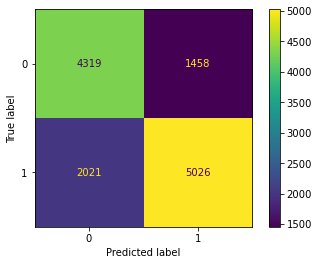

In [13]:
decision_tree = DecisionTreeClassifier(random_state = 69)
decision_tree.fit(X_train_clean, y_train)

score_maxtrix_printer(decision_tree, X_train_clean, y_train, X_test_clean, y_test)

Unsurprisingly the model is severly overfit with an accuracy score of 99% and precision score of 99% on the training set in comparison to the accuracy score of 70% and precision score of 74% on our testing set.

---
## Grid Search for Model 2 Optimal Parameters

We utilized Grid Search to find the optimal hyper-parameters for our Decision Tree model.

In [14]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_clean, y_train)

DecisionTreeClassifier()

In [15]:
param_dict = {
    "criterion":['gini', 'entropy'],
    "max_depth":[1, 10, 25, 50],
    "min_samples_split":range(1, 10),
    "min_samples_leaf":range(1, 10)
}

In [16]:
# tw = GridSearchCV(estimator=decision_tree,
#                  param_grid=param_dict,
#                  cv=5,
#                  verbose=1,
#                  n_jobs=-1)
# tw.fit(X_train_clean, y_train)

In [17]:
# print(tw.best_params_)
# print(tw.best_estimator_)
# print(tw.best_score_)

Here we found that the best parameters for our Decision Tree model are <br>`criterion = 'gini', max_depth = 25, min_samples_leaf = 7`

Kept getting different `min_samples_split` value without results changing so it seems `criterion`, `max_depth`, & and `min_samples_leaf` give us a consistent enough result that `min_samples_split` does not need to be manipulated by us.

---
## Model 2 (Decision Tree) with Optimized Parameters


    Train Accuracy: 0.8749382619771764
    Train Precision: 0.8799249530956847
    Test Accuracy: 0.7585776668746101
    Test Precision: 0.7886891714160456
    


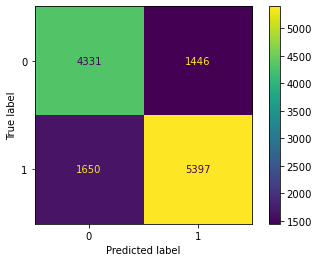

In [18]:
decision_tree_better = DecisionTreeClassifier(random_state = 69, criterion = 'gini', 
                                              max_depth = 25, min_samples_leaf = 7)
decision_tree_better.fit(X_train_clean, y_train)

score_maxtrix_printer(decision_tree_better, X_train_clean, y_train, X_test_clean, y_test)

With our optimized parameters, this decision tree performed much better than our first attempt, with new training  accuracy and precion scores of nearly 88% and a test accuracy and precion scores of 74%.

---
## Feature Importance & Model 3 (Logisitc Regression) Using Top Predictors

Next, we used the `ExtraTreesClassifier()` to identify the features with the highest importance.

[1.53980703e-02 7.06818262e-02 1.37624020e-01 1.36030000e-01
 4.70170362e-02 1.01638099e-02 1.48652728e-03 1.04173191e-02
 5.35186874e-03 7.93874622e-04 1.14132393e-02 3.33126952e-03
 1.13435311e-03 5.48979928e-03 3.78295705e-03 4.52871934e-03
 4.69525551e-03 5.81092931e-03 4.55708559e-03 3.85212482e-03
 4.68392103e-03 8.46291103e-04 2.40021907e-03 1.09967141e-02
 2.47109325e-03 3.08348346e-03 3.66795074e-03 1.64958314e-03
 2.77025985e-03 2.21437142e-03 2.53542473e-03 2.23587748e-03
 2.10832973e-03 2.66959483e-03 2.99580967e-03 2.32453339e-03
 2.35129786e-03 2.16032504e-03 1.48507243e-03 1.72731633e-03
 2.74050368e-03 1.37760308e-03 1.38497864e-03 1.43553536e-03
 6.73276494e-03 1.93770708e-03 2.63080943e-03 4.30625050e-03
 3.68588814e-03 1.40097427e-02 9.40404255e-03 6.74908514e-03
 7.11244151e-03 1.22623932e-02 1.19142041e-02 6.36377232e-03
 1.16521667e-02 3.94360202e-03 3.17923717e-02 9.27497177e-04
 7.82720849e-03 5.07840391e-04 8.50363548e-04 1.90991846e-04
 1.38319521e-03 2.735965

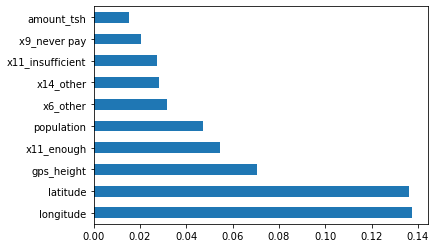

In [19]:
model = ExtraTreesClassifier()
model.fit(X_train_clean, y_train)

print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index = X_train_clean.columns)
feat_importances.nlargest(10).plot(kind = 'barh')
plt.show()

In [20]:
importance_col = ['longitude', 'latitude', 'gps_height', 'quantity', 
                  'status_group', 'population', 'waterpoint_type', 
                 'extraction_type_class', 'payment_type', 'amount_tsh']
df_importance = df2[importance_col]

---
 We then used our top 10 most important features to predict our model using logistic regression.

In [21]:
y_Ext = df_importance.status_group
X_Ext = df_importance.drop('status_group', axis = 1)

X_train_Ext, X_test_Ext, y_train_Ext, y_test_Ext = train_test_split(X_Ext, y_Ext, 
                                                        test_size = 0.25, random_state = 69)

In [22]:
X_train_clean_Ext = split_join(X_train_Ext)
X_test_clean_Ext = split_join(X_test_Ext)


    Train Accuracy: 0.7301983415217448
    Train Precision: 0.6905649555491826
    Test Accuracy: 0.7339363693075484
    Test Precision: 0.6994841400504884
    


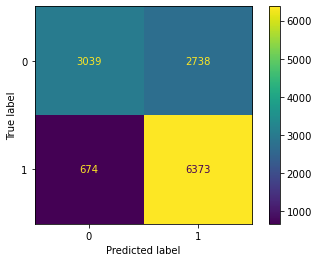

In [23]:
logreg_clf_Ext = LogisticRegression(random_state = 69, max_iter = 1000)
logreg_model_Ext = logreg_clf_Ext.fit(X_train_clean_Ext, y_train_Ext)

score_maxtrix_printer(logreg_model_Ext, X_train_clean_Ext, y_train_Ext, X_test_clean_Ext, y_test_Ext)

So the top 10 predictors we recived from our `ExtraTreesClassifier()` had a 73% accuracy score and 69% precision score of our test data when using a `LogisticRegression()`. Next, we ran a new Logisitc Regression model which utilized all predictor columns available.

---
## Model 4 (Logistic Regression) Utilizing All Predictors


    Train Accuracy: 0.760846395799215
    Train Precision: 0.7430346927857113
    Test Accuracy: 0.7614628820960698
    Test Precision: 0.7472718253968254
    


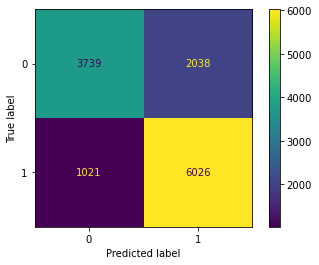

In [24]:
logreg_clf = LogisticRegression(random_state = 69, max_iter = 1000)
logreg_model = logreg_clf.fit(X_train_clean, y_train)

score_maxtrix_printer(logreg_model, X_train_clean, y_train, X_test_clean, y_test)

With all predictors, both our training and testing sets' metrics improved. Accuracy had gone up to 76% and precision reached 74%.


---
## Grid Search for Model 5 Optimal Parameters

For our final indivdual model, we again utilized Grid Search to find the optimal hyper-parameters for a kNN model.


In [25]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_clean, y_train)
grid = {
    'n_neighbors': range(1, 15),
    'metric': ['manhattan', 'minkowski'],
    'weights' : ['distance', 'uniform']
}

In [26]:
# gs = GridSearchCV(estimator = knn_model, param_grid = grid, cv = 5, verbose = 1, n_jobs = -1)
# gs.fit(X_train_clean, y_train)

In [27]:
# gs.best_params_

Here we found that the best parameters for our kNN model are <br>  `n_neighbors = 14, metric = 'manhattan', weights = 'distance'`

---
## Model 5 (K Nearest Neighbors) with Optimized Parameters

We next ran a new `KNeighborsClassifier()` model with our optimal hyperparameters to see what metric results we would get for our training and testing sets.


    Train Accuracy: 0.9955028724427462
    Train Precision: 0.996568487274807
    Test Accuracy: 0.799516531503431
    Test Precision: 0.7991978609625668
    


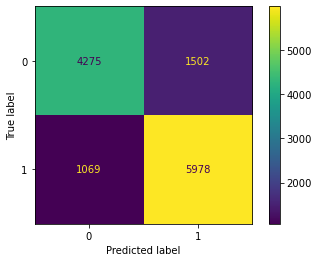

In [28]:
knn_better = KNeighborsClassifier(14, metric = "manhattan", weights = 'distance') 
knn_better.fit(X_train_clean, y_train)

score_maxtrix_printer(knn_better, X_train_clean, y_train, X_test_clean, y_test)

While our kNN model overfit on our training data, our testing data metrics were the best so far  us our best testing results so far, with an accuracy score and a precison score of 80%.

---
## Final Model with an Ensemble Model

We decided to use `VotingClassifier()` to combine our models together to get optimal performance. We chose to give our optimized kNN model the most weight (50%), as it performed the best in both accuracy and precision on testing data. We split the remaining weight percentage equally between our optimized decision tree model and logisitc regression model (25% each).

In [29]:
avg = VotingClassifier(estimators=[ ('lr', logreg_model),
                                    ('dt', decision_tree_better),
                                    ('knn', knn_better)],
                                     weights = [0.25, 0.25, 0.5])
avg.fit(X_train_clean, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=69)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=25,
                                                     min_samples_leaf=7,
                                                     random_state=69)),
                             ('knn',
                              KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=14,
                                                   weights='distance'))],
                 weights=[0.25, 0.25, 0.5])


    Ensemble CV Score: 0.8042630621263323
    Final Test Accuracy: 0.8018558951965066
    Final Test Precision: 0.8198466780238501



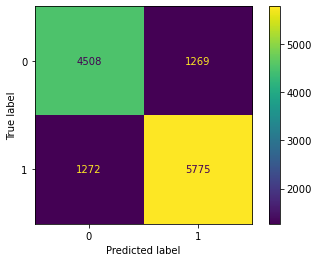

In [30]:
#This block may take a minute because it is run on the ensemble
scores = cross_val_score(estimator = avg, X = X_train_clean, y = y_train, cv = 5)

print(f"""
    Ensemble CV Score: {np.median(scores)}
    Final Test Accuracy: {accuracy_score(y_test, avg.predict(X_test_clean))}
    Final Test Precision: {precision_score(y_test, avg.predict(X_test_clean))}
""")
plot_confusion_matrix(avg, X_test_clean, y_test);

Our ensemble model outperformed our earlier models. 
#### On our testing set we achieved a fantastic 81% accuracy score and 82% precision score!

---

Taking a look at our TPR and FPR we can see that our model is very good at properly identifying true positives while have a good false positive rate as well.

In [31]:
cm = confusion_matrix(y_test, avg.predict(X_test_clean))

tp, tn, fp, fn = cm[1][1], cm[0][0], cm[0][1], cm[1][0]
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print(f"""
    True Positive Rate: {tpr}
    False Positive Rate: {fpr}
""")


    True Positive Rate: 0.8194976585781183
    False Positive Rate: 0.21966418556344122



---
## Data Cleaning on the True Test Data

Below we prepared the data of the true test set exactly the same way as we did when prepairing the training data set eariler. Due to this being the true testing data, there were no target values provided to compare our final predictions with (meaning we were unable to calculate our accuracy and precision scores).

In [37]:
df3 = data_cleaning(df_test)
Ftest = split_join(df3)
df3['targets'] = avg.predict(Ftest)

Now that we have prepared our test data, we use our ensemble model 'avg' to predict the target for the `Ftest` DataFrame and add it to the DataFrame as a new column,`targets`

---
## Mapping Our Test Data Results

Now that we have used our model to predict the functioning status of our wells, we can plot it on a map of Tanzania to see which regions are in most need of aid. 
* This code has been commented out due to errors that occur if geopandas and contextily are not properly installed. An image of the resulting graph has been posted.

In [2]:
# drop_zeros = df3.loc[(df3['longitude'] != 0.0) & (df3['latitude'] != 0.0)]

# fig, ax = plt.subplots(figsize=(18,12))

# countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# drop_zeros
# sns.scatterplot(x = drop_zeros['longitude'], y = drop_zeros['latitude'], hue = drop_zeros["targets"], \
#                 palette = ["red", "blue"], alpha = .5)

# ax.grid(b=True, alpha=0.5)

# cx.add_basemap(ax, crs=countries.crs.to_string())

# ax.set(title='Combined Wells, 0 = Broken, 1 = Working')
# plt.legend(title='Wells', loc='upper right', labels=['Need Repair', 'Working'])

# plt.show()

## fig.savefig("combo.png") # Saving the resulting map as a .png file

![Combined Map](images/combo.png)


From this figure it can be seen that inland, on the southern Tanzanian boarder, there are many wells in need of repair. You can also see few functioning wells in this same area meaning these communities will have to travel farther to get access to drinking water. Regions like these definitely should be focused on when considering where to immediately begin aid.

# 5. Evaluation
---

---

# 6. Appendix

### Wells in need of repair, plotted in red. 
* This code has been commented out due to errors that occur if geopandas and contextily are not properly installed. An image of the resulting graph has been posted.

In [35]:
# temp_0 = df3.loc[(df3['longitude'] != 0.0) & (df3['latitude'] != 0.0)]


# temp_00 = temp_0.loc[(df3['targets'] == 0)]

# dropper = temp_00

# fig, ax = plt.subplots(figsize=(18,12))

# countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# sns.scatterplot(x = dropper['longitude'], y = dropper['latitude'], color = "red", alpha = .5)

# ax.grid(b=True, alpha=0.5)

# cx.add_basemap(ax, crs=countries.crs.to_string())
# ax.set(title='Need Repair')


# plt.show()
## fig.savefig("need_repair.png") # Saving the resulting map as a .png file



![Wells Needing Repair Map](images/need_repair.png)

### Wells that are fully functional, plotted in blue. 
* This code has been commented out due to errors that occur if geopandas and contextily are not properly installed. An image of the resulting graph has been posted.

In [36]:
# temp_1 = df3.loc[(df3['longitude'] != 0.0) & (df3['latitude'] != 0.0)]


# temp_11 = temp_1.loc[(df3['targets'] == 1)]
b
# dropper_1 = temp_11

# fig, ax = plt.subplots(figsize=(18,12))

# countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


# sns.scatterplot(x = dropper_1['longitude'], y = dropper_1['latitude'], color = "blue", alpha = .5)

# ax.grid(b=True, alpha=0.5)

# cx.add_basemap(ax, crs=countries.crs.to_string())

# ax.set(title='Functioning Wells')

# plt.show()

 
## fig.savefig("working.png") # Saving the resulting map as a .png file

![Functioning Well Map](images/working.png)
